In [1]:
!pip install torchinfo

In [2]:
import time
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import numpy as np
import cv2
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from torchinfo import summary
import torchvision.models as models
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import OrderedDict
import platform
import psutil
import random
import glob
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from torchvision.transforms import ColorJitter, RandomRotation, RandomResizedCrop
from torchvision.transforms.functional import gaussian_blur
from PIL import ImageOps
from tabulate import tabulate

In [3]:
cpu_info = platform.processor()

ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)

try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"

print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

CPU: x86_64
Total RAM (GB): 31.35
GPU: Tesla P100-PCIE-16GB


In [4]:
import random
import numpy as np
import tensorflow as tf

# Set seeds for reproducibility
seed = 1
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)


2025-07-13 03:11:04.655515: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752376264.850015      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752376264.908673      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
data_dir = "/kaggle/input/rice-varieties-in-bangladesh/Augmented"

file_paths = []
labels = []

for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    for image_name in os.listdir(class_dir):
        file_paths.append(os.path.join(class_dir, image_name))
        labels.append(class_name)

df = pd.DataFrame({"file_path": file_paths, "label": labels})
df = df.sample(frac=1).reset_index(drop=True)

Class: BD87, Count: 2000
Class: Binadhan19, Count: 2000
Class: BD79, Count: 2000
Class: BD91, Count: 2000
Class: Binadhan17, Count: 2000
Class: Binadhan11, Count: 2000
Class: BD75, Count: 2000
Class: BD33, Count: 2000
Class: BD51, Count: 2000
Class: Binadhan10, Count: 2000
Class: Binadhan24, Count: 2000
Class: BRRI102, Count: 2000
Class: Binadhan16, Count: 2000
Class: Binadhan14, Count: 2000
Class: BD76, Count: 2000
Class: BD56, Count: 2000
Class: Binadhan8, Count: 2000
Class: Binadhan26, Count: 2000
Class: BD57, Count: 2000
Class: BD95, Count: 2000
Class: BR23, Count: 2000
Class: Binadhan20, Count: 2000
Class: Binadhan25, Count: 2000
Class: BD39, Count: 2000
Class: BD72, Count: 2000
Class: Binadhan7, Count: 2000
Class: BR22, Count: 2000
Class: BD49, Count: 2000
Class: BD30, Count: 2000
Class: Binadhan23, Count: 2000
Class: BD85, Count: 2000
Class: BD93, Count: 2000
Class: Binadhan21, Count: 2000
Class: BRRI67, Count: 2000
Class: BRRI74, Count: 2000
Class: BD52, Count: 2000
Class: BD70

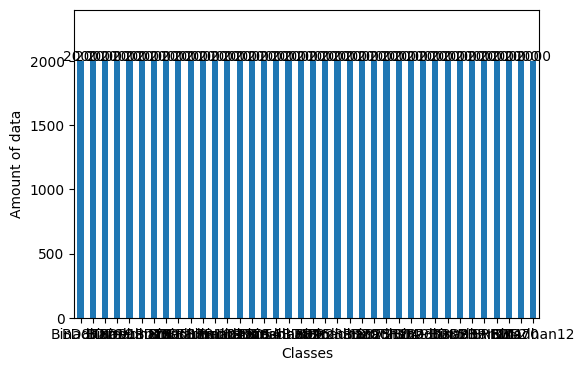

In [6]:
class_counts_train = df['label'].value_counts()

for class_name, count in class_counts_train.items():
    print(f"Class: {class_name}, Count: {count}")

plt.figure(figsize=(6, 4))
ax = class_counts_train.plot(kind='bar')
plt.xlabel('Classes')
plt.ylabel('Amount of data')
plt.xticks(rotation=360)
for i, count in enumerate(class_counts_train):
    ax.text(i, count + 5, str(count), ha='center')
plt.ylim(0, max(class_counts_train) * 1.2)
plt.show()

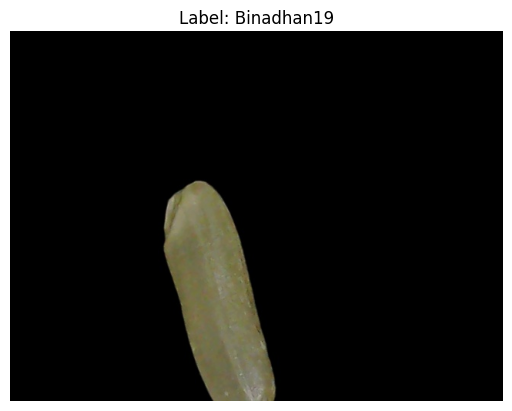

In [8]:
random_index = random.randint(1, len(df) - 1)
random_row = df.iloc[random_index]

file_path = random_row['file_path']
label = random_row['label']

image = Image.open(file_path)
plt.imshow(image)
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

In [10]:
train_dataframe, temp_dataframe = train_test_split(df, test_size=0.30, 
                                     stratify=df['label'], random_state=42)
valid_dataframe, test_df = train_test_split(temp_dataframe, test_size=0.50, 
                                            stratify=temp_dataframe['label'], random_state=42)

In [11]:
print("Training Data: ", len(train_dataframe))
print("Validation Data: ", len(valid_dataframe))
print("Test Data: ", len(test_df))
print("-------------------------------------------")
print("Total amounts of data in the dataset: ", len(df))

Training Data:  53200
Validation Data:  11400
Test Data:  11400
-------------------------------------------
Total amounts of data in the dataset:  76000


In [12]:
class_counts_train = train_dataframe['label'].value_counts()
class_counts_valid = valid_dataframe['label'].value_counts()
class_counts_test = test_df['label'].value_counts()

train_table_data = [[class_name, count] for class_name, count in class_counts_train.items()]
valid_table_data = [[class_name, count] for class_name, count in class_counts_valid.items()]
test_table_data = [[class_name, count] for class_name, count in class_counts_test.items()]

print("Train Dataset")
print(tabulate(train_table_data, headers=["Class", "Count"]))
print("\nValidation Dataset")
print(tabulate(valid_table_data, headers=["Class", "Count"]))
print("\nTest Dataset")
print(tabulate(test_table_data, headers=["Class", "Count"]))

Train Dataset
Class         Count
----------  -------
BR22           1400
BRRI67         1400
Binadhan14     1400
Binadhan25     1400
BD57           1400
BRRI102        1400
BD30           1400
BD33           1400
BD70           1400
Binadhan7      1400
BR23           1400
Binadhan17     1400
BD95           1400
BD72           1400
Binadhan20     1400
Binadhan8      1400
BD91           1400
BD93           1400
BD79           1400
BD51           1400
BD75           1400
Binadhan11     1400
BD52           1400
BD49           1400
Binadhan26     1400
Binadhan19     1400
BD76           1400
BD87           1400
BD56           1400
Binadhan21     1400
Binadhan12     1400
BD39           1400
Binadhan16     1400
BD85           1400
Binadhan24     1400
Binadhan23     1400
BRRI74         1400
Binadhan10     1400

Validation Dataset
Class         Count
----------  -------
BD30            300
Binadhan16      300
BD52            300
BRRI74          300
BD57            300
Binadhan8       300
BD76  

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
save_path_checkpoints = "/kaggle/working/"
os.makedirs(save_path_checkpoints, exist_ok=True)

In [16]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/input/rice-varieties-in-bangladesh/Augmented",
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(224, 224),   # Match your model's input
    batch_size=32
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/input/rice-varieties-in-bangladesh/Augmented",
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(224, 224),
    batch_size=32
)


Found 76000 files belonging to 38 classes.
Using 60800 files for training.


I0000 00:00:1752376845.837775      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 76000 files belonging to 38 classes.
Using 15200 files for validation.


In [23]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))


In [24]:
import tensorflow as tf
from tensorflow.keras import layers

# -----------------------------
# 1️⃣ Paths & Config
# -----------------------------
DATASET_PATH = "/kaggle/input/rice-varieties-in-bangladesh/Augmented"  # <-- adjust if needed
IMG_SIZE = (224, 224)  # Must match your model
BATCH_SIZE = 32
SEED = 42

# -----------------------------
# 2️⃣ Load Training & Validation Datasets
# -----------------------------
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# -----------------------------
# 3️⃣ Inspect classes
# -----------------------------
class_names = train_ds.class_names
print("Classes:", class_names)
print("Number of classes:", len(class_names))

# -----------------------------
# 4️⃣ Normalization Layer
# -----------------------------
normalization_layer = layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# -----------------------------
# 5️⃣ Prefetch for performance
# -----------------------------
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

print("✅ Data pipeline ready!")


Found 76000 files belonging to 38 classes.
Using 60800 files for training.
Found 76000 files belonging to 38 classes.
Using 15200 files for validation.
Classes: ['BD30', 'BD33', 'BD39', 'BD49', 'BD51', 'BD52', 'BD56', 'BD57', 'BD70', 'BD72', 'BD75', 'BD76', 'BD79', 'BD85', 'BD87', 'BD91', 'BD93', 'BD95', 'BR22', 'BR23', 'BRRI102', 'BRRI67', 'BRRI74', 'Binadhan10', 'Binadhan11', 'Binadhan12', 'Binadhan14', 'Binadhan16', 'Binadhan17', 'Binadhan19', 'Binadhan20', 'Binadhan21', 'Binadhan23', 'Binadhan24', 'Binadhan25', 'Binadhan26', 'Binadhan7', 'Binadhan8']
Number of classes: 38
✅ Data pipeline ready!


In [28]:
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

total_class = 38
learning_rate = 0.0001
train_batch = 32  # define your batch size here

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = resnet50(weights=ResNet50_Weights.DEFAULT)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, total_class)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

summary(model, input_size=(3, 224, 224))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [29]:
import time

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim

model = nn.Sequential(
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

# Send model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Example loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Example DataLoaders (must be defined)
dataloader_train_dataset = "/kaggle/input/rice-varieties-in-bangladesh/Augmented"
dataloader_valid_dataset = "/kaggle/input/rice-varieties-in-bangladesh/Augmented"

save_path_checkpoints = "./checkpoints"

In [31]:
from tqdm import tqdm

In [33]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from tqdm import tqdm
import pandas as pd
import random
import numpy as np

# === Set random seeds for reproducibility ===
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# === Device ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# === Data transforms ===
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

transform_valid = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# === Dataset paths - update these to your actual paths ===
train_dir = "/kaggle/input/rice-varieties-in-bangladesh/Augmented"  # replace with your train folder path
valid_dir = "/kaggle/input/rice-varieties-in-bangladesh/Augmented"  # replace with your valid folder path

# === Load datasets ===
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform_train)
valid_dataset = datasets.ImageFolder(root=valid_dir, transform=transform_valid)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

# === Model ===
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(train_dataset.classes))
model = model.to(device)

# === Loss and optimizer ===
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# === Learning rate scheduler ===
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)

# === Checkpoints directory ===
save_path_checkpoints = "./checkpoints"
os.makedirs(save_path_checkpoints, exist_ok=True)

# === Training function ===
def train_model(model, criterion, optimizer, scheduler, train_loader, valid_loader, num_epochs=20, early_stop_patience=5, save_path_checkpoints="checkpoints"):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    best_val_acc = 0.0
    consecutive_no_improvement = 0
    num_epochs_loss_greater = 0

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
        for i, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs}")
            progress_bar.set_postfix(loss=running_loss / total_train, acc=correct_train / total_train)

        epoch_train_loss = running_loss / total_train
        epoch_train_acc = correct_train / total_train
        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)

        print(f'Training Loss: {epoch_train_loss:.3f} Acc: {epoch_train_acc:.3f}')

        # Validation
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, predicted = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_loss / total_val
        epoch_val_acc = correct_val / total_val
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)

        print(f'Validation Loss: {epoch_val_loss:.3f} Acc: {epoch_val_acc:.3f}')

        # Step scheduler
        scheduler.step(epoch_val_acc)

        # Early stopping
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_epoch = epoch + 1
            filepath = f"{save_path_checkpoints}/model.pt"
            checkpoint = {
                "epoch": epoch + 1,
                "model_weight": model.state_dict(),
                "optimizer_state": optimizer.state_dict()
            }
            torch.save(checkpoint, filepath)
            print(f"Best model saved at epoch {best_epoch} with validation accuracy: {best_val_acc:.3f}")
            consecutive_no_improvement = 0
        else:
            consecutive_no_improvement += 1

        if epoch_val_loss > epoch_train_loss:
            num_epochs_loss_greater += 1
        else:
            num_epochs_loss_greater = 0

        if consecutive_no_improvement >= early_stop_patience or num_epochs_loss_greater >= early_stop_patience:
            print(f"Early stopping triggered. Training stopped.")
            break

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

# === Run training ===
start_time = time.time()

train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(
    model, criterion, optimizer, scheduler,
    train_loader, valid_loader,
    save_path_checkpoints=save_path_checkpoints
)

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds ---> {training_time/60:.2f} minutes")

# === Save training history ===
data = {
    'Epoch': list(range(1, len(train_loss_history) + 1)),
    'Train Loss': train_loss_history,
    'Train Accuracy': train_acc_history,
    'Validation Loss': val_loss_history,
    'Validation Accuracy': val_acc_history
}

history = pd.DataFrame(data)
history.to_excel('./training_data.xlsx', index=False)
print("Training history saved to training_data.xlsx")


Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 222MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/20: 100%|██████████| 2375/2375 [15:12<00:00,  2.60it/s, acc=0.618, loss=1.12]


Training Loss: 1.124 Acc: 0.618
Validation Loss: 1.235 Acc: 0.614
Best model saved at epoch 1 with validation accuracy: 0.614


Epoch 2/20: 100%|██████████| 2375/2375 [09:13<00:00,  4.29it/s, acc=0.754, loss=0.713]


Training Loss: 0.713 Acc: 0.754
Validation Loss: 8.423 Acc: 0.164


Epoch 3/20: 100%|██████████| 2375/2375 [08:50<00:00,  4.47it/s, acc=0.804, loss=0.567]


Training Loss: 0.567 Acc: 0.804
Validation Loss: 5.192 Acc: 0.354


Epoch 4/20: 100%|██████████| 2375/2375 [08:53<00:00,  4.45it/s, acc=0.839, loss=0.464]


Training Loss: 0.464 Acc: 0.839
Validation Loss: 3.408 Acc: 0.371


Epoch 5/20: 100%|██████████| 2375/2375 [08:55<00:00,  4.44it/s, acc=0.865, loss=0.389]


Training Loss: 0.389 Acc: 0.865
Validation Loss: 0.837 Acc: 0.747
Best model saved at epoch 5 with validation accuracy: 0.747
Early stopping triggered. Training stopped.
Training Time: 5170.15 seconds ---> 86.17 minutes
Training history saved to training_data.xlsx


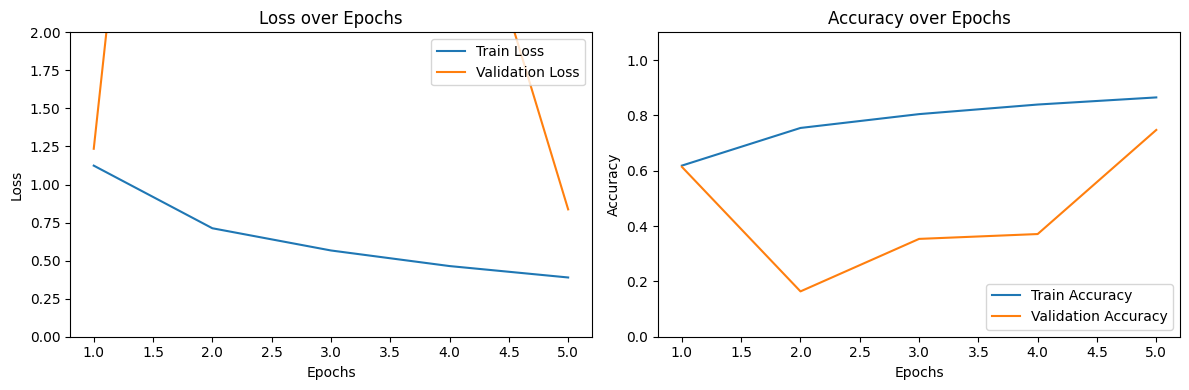

In [34]:
# ✅ Install matplotlib if needed (usually not needed on Kaggle)
!pip install matplotlib

# ✅ Import libraries
import pandas as pd
import matplotlib.pyplot as plt

# ✅ Load training history from Excel
history = pd.read_excel('/kaggle/working/training_data.xlsx')

# ✅ Create plots
plt.figure(figsize=(12, 4))

# 📉 Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history['Epoch'], history['Train Loss'], label='Train Loss')
plt.plot(history['Epoch'], history['Validation Loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend(loc='upper right')
plt.ylim(0, 2)

# 📈 Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history['Epoch'], history['Train Accuracy'], label='Train Accuracy')
plt.plot(history['Epoch'], history['Validation Accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend(loc='lower right')
plt.ylim(0, 1.1)

# ✅ Show plots
plt.tight_layout()
plt.show()


In [35]:
def evaluate_model(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / total
    accuracy = correct / total

    return loss, accuracy

In [39]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Dataset
valid_dataset = datasets.ImageFolder(
    root="/kaggle/input/rice-varieties-in-bangladesh/Augmented",
    transform=transform
)

# DataLoader
dataloader_valid_dataset = DataLoader(valid_dataset, batch_size=32, shuffle=False)

# Model
model = models.resnet18(weights=None)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(valid_dataset.classes))
model = model.to(device)

# Loss + optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Load checkpoint
checkpoint = torch.load("./checkpoints/model.pt", map_location=device)
model.load_state_dict(checkpoint["model_weight"])
optimizer.load_state_dict(checkpoint["optimizer_state"])
best_epoch = checkpoint["epoch"]

print(f"Loaded checkpoint from epoch {best_epoch}")

# Evaluate function
def evaluate_model(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / total
    avg_acc = correct / total
    return avg_loss, avg_acc

# ✅ Run evaluation
val_loss, val_acc = evaluate_model(model, criterion, dataloader_valid_dataset)
print(f"✅ Best model - Validation Loss: {val_loss:.3f}, Validation Accuracy: {val_acc:.3f}")


Loaded checkpoint from epoch 5
✅ Best model - Validation Loss: 0.837, Validation Accuracy: 0.747


In [40]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

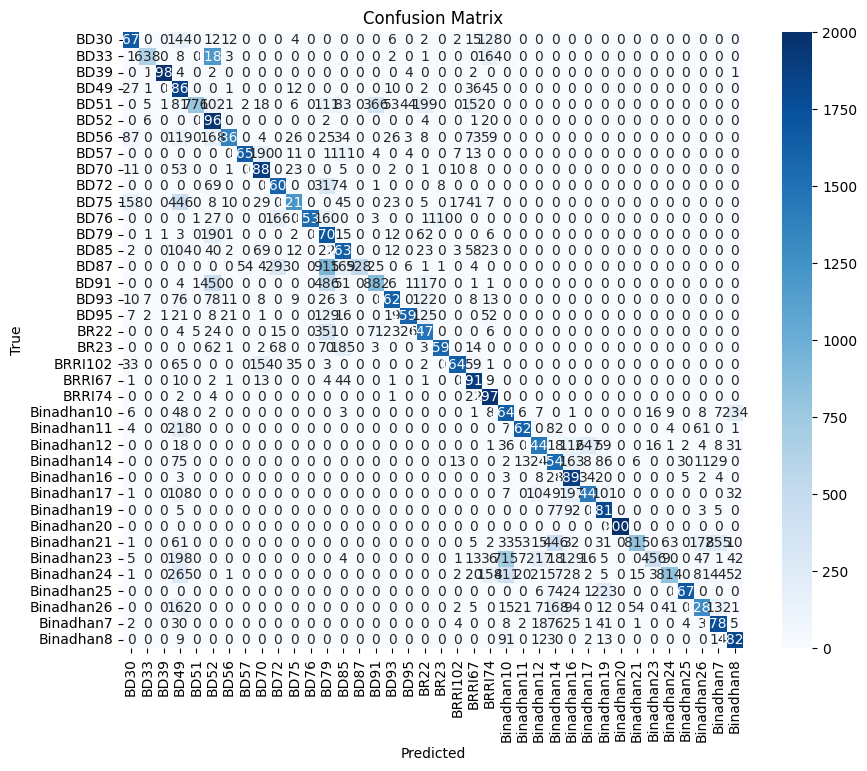

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [66]:
import torch
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# === 1️⃣ Load your training history (optional) ===
history = pd.read_excel('/kaggle/working/training_data.xlsx')

# === 2️⃣ Load your checkpoint ===
save_path_checkpoints = "./checkpoints"
best_checkpoint_path = f"{save_path_checkpoints}/model.pt"
checkpoint = torch.load(best_checkpoint_path)

model.load_state_dict(checkpoint["model_weight"])
optimizer.load_state_dict(checkpoint["optimizer_state"])
best_epoch = checkpoint["epoch"]

print(f"✅ Loaded checkpoint from epoch {best_epoch}")

# === 3️⃣ Make sure you have the same device ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# === 4️⃣ Make sure your class names match the model output ===
class_names = train_dataset.classes  # 👈 Always get it directly from dataset!
print(f"✅ Classes from dataset: {class_names}")
print(f"✅ Number of dataset classes: {len(class_names)}")
print(f"✅ Model output layer: {model.fc}")
print(f"✅ Model output features: {model.fc.out_features}")

# === Check for mismatch ===
if len(class_names) != model.fc.out_features:
    raise ValueError(
        f"🚫 Mismatch! Dataset has {len(class_names)} classes, "
        f"but model outputs {model.fc.out_features} classes. "
        f"Fix this before running evaluation!"
    )

# === 5️⃣ Define safe evaluation with report ===
from tqdm import tqdm

def evaluate_with_report(model, dataloader, class_names, max_batches=None):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for i, batch in enumerate(tqdm(dataloader, desc="Evaluating")):
            # Defensive unpacking
            if isinstance(batch, (list, tuple)) and len(batch) == 2:
                inputs, labels = batch
            else:
                raise ValueError(f"Unexpected batch format: {batch}")

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

            if max_batches and i + 1 >= max_batches:
                print(f"✅ Stopped after {max_batches} batches for quick test.")
                break

    print("\n✅ Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    print("\n✅ Confusion Matrix:")
    print(cm)

    return all_labels, all_preds, cm

# === 6️⃣ Run it ===

labels, preds, cm = evaluate_with_report(
    model,
    dataloader_valid_dataset,
    class_names,
    max_batches=None  # 👉 Use None to run full validation
)


✅ Loaded checkpoint from epoch 5
✅ Classes from dataset: ['BD30', 'BD33', 'BD39', 'BD49', 'BD51', 'BD52', 'BD56', 'BD57', 'BD70', 'BD72', 'BD75', 'BD76', 'BD79', 'BD85', 'BD87', 'BD91', 'BD93', 'BD95', 'BR22', 'BR23', 'BRRI102', 'BRRI67', 'BRRI74', 'Binadhan10', 'Binadhan11', 'Binadhan12', 'Binadhan14', 'Binadhan16', 'Binadhan17', 'Binadhan19', 'Binadhan20', 'Binadhan21', 'Binadhan23', 'Binadhan24', 'Binadhan25', 'Binadhan26', 'Binadhan7', 'Binadhan8']
✅ Number of dataset classes: 38
✅ Model output layer: Linear(in_features=512, out_features=38, bias=True)
✅ Model output features: 38


Evaluating: 100%|██████████| 2375/2375 [04:57<00:00,  7.97it/s]


✅ Classification Report:
              precision    recall  f1-score   support

        BD30       0.82      0.84      0.83      2000
        BD33       0.97      0.32      0.48      2000
        BD39       1.00      0.99      1.00      2000
        BD49       0.44      0.93      0.60      2000
        BD51       0.99      0.39      0.56      2000
        BD52       0.45      0.98      0.61      2000
        BD56       0.95      0.68      0.80      2000
        BD57       0.97      0.83      0.89      2000
        BD70       0.79      0.94      0.86      2000
        BD72       0.75      0.80      0.77      2000
        BD75       0.90      0.61      0.72      2000
        BD76       1.00      0.77      0.87      2000
        BD79       0.39      0.85      0.54      2000
        BD85       0.68      0.81      0.74      2000
        BD87       1.00      0.26      0.42      2000
        BD91       0.65      0.44      0.53      2000
        BD93       0.89      0.81      0.85      2000
 